#### Version's detail (pour qu'on s'y retrouve)
V2 : Able to parse over wiki page info and turn into csv doc. Strugles with special character and disambiguation pages. Citations counts are weird

V2.1 : Solved the special character problem

V2.2 : Cleaned the table and formated the date. Added a little hist to view page creation along time

V2.3 : Adding a function to pass the 500 treshhold in scraping articles title

V2.4 : Adding the scraping of the titles of sub- and sub-sub-sections

In [2]:
!pip install wikipedia setuptools pywikibot mwparserfromhell pandas numpy scipy nltk tqdm seaborn pyqt5 pyqtwebengine ruamel-yaml lxml

In [1]:
import wikipedia
import re
import pywikibot
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json


In [2]:
wikipedia.set_lang("en")  #We make our research in english

#### definition of the function for the CORPUS SELECTION

In [84]:
def function_to_get_all_the_bloody_titles(key_words : str)-> (list[str],int):
    ''' 
    
    '''
    titles = []
    a = key_words.lower().replace(' ', '+')
    scraped_url = 'https://en.wikipedia.org/w/index.php?title=Special:Search&limit=5000&offset=0&profile=default&search={}&ns0=1'.format(a)
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find('div', {'class' : 'results-info'})
    nbr_result = int(r.get('data-mw-num-results-total'))
    for interest in soup.find_all('div', {'class' : 'mw-search-result-heading'}):
        titles.append(interest.find('a')['title'])
    return titles, nbr_result

In [4]:
def get_section_titles(page : str) -> list[str]:
    '''
    Returns the section titles

    :param page: Title of the page
    :return: The list of section titles
    '''
    section_tit = set()
    section_title = []
    scraped_url = wikipedia.page(page, auto_suggest = False).url
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find_all('h2') + soup.find_all('h3') + soup.find_all('h4')
    for i in r:
        if i.find('span', {'class' : 'mw-headline'}) is not None:
            section_tit.add(i.find('span', {'class' : 'mw-headline'})['id'])
    for i in section_tit:
        section_title.append(i.replace('_', ' '))        
    return section_title

In [5]:
#We define a function to automatically set up a corpus of related articles
def corpus_selection(word_keys : str , number_of_results, key_for_section) -> list[str]:
    '''
    Select the corpus if the keywords are in the section or in the title

    :param word_keys : string 
    
    :return: a dictionnary containing the title of all the pages of the corpus
    '''
    corpus = []
    proper_list = []
    left_list = []
    function = function_to_get_all_the_bloody_titles(word_keys)
    nbr_result = function[1]
    search_list = function[0] #Select and put in a list number_of_results wikipedia articles related to word_keys
    
    for article in tqdm(search_list):
        try:
            wikipedia.summary(article, auto_suggest = False)
            proper_list.append(article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                wikipedia.summary(article, auto_suggest = False)
                proper_list.append(article)
            except wikipedia.exceptions.PageError as e:
                pass
    
    for proper_article in tqdm(proper_list):
        if key_for_section in proper_article.lower(): #Among these articles, select the ones whose title contains key_for_selection for the corpus
            corpus.append(proper_article)
        else:
            left_list.append(proper_article) #Put the rest of the articles in a list
            
    for left_article in tqdm(left_list):
        sec_tit = []
        try :
            sec_tit = get_section_titles(left_article)
            for section in sec_tit:
                if key_for_section.lower() in section.lower() and left_article not in corpus:
                    corpus.append(left_article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                sec_tit = get_section_titles(left_article)
                for section in sec_tit:
                    if key_for_section.lower() in section.lower() and left_article not in corpus:
                        corpus.append(left_article)
            except wikipedia.exceptions.PageError as e:
                pass

    return corpus[:number_of_results]

## TO LAUNCH THE CORPUS SELECTION

In [7]:
%%time
search_list = corpus_selection("Effects of climate change", 5000, 'climate change')


  1%|▉                                                                               | 57/5000 [00:30<42:35,  1.93it/s]C:\Users\aaugr\anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\aaugr\anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
100%|██████████████████████████████████████████████████████████████████████████████| 4776/4776 [46:31<00:00,  1.71it/s]

Wall time: 1h 31min 5s


In [8]:
len(search_list)

921

In [82]:
df = pd.read_csv("Corpus_crispr_allV2.csv") 
df.set_index("Unnamed: 0",inplace=True)
search_list=list(df.loc[:,"Name only"])

In [87]:
search_list=["Effects of climate change"]

### Get the information on the protected articles of the corpus

In [ ]:
def protection_status(data):
    
    years_off = []
    for i in range(22):
        years_off.append(2001+i)
    
    wrong_ones = []
    dot = pd.DataFrame(years_off)
    
    for article in data:
        
        html_text = requests.get(('https://en.wikipedia.org/wiki/Special:Log?type=protect&user=&page={}&wpdate=&tagfilter=&subtype=').format(article)).text
        soup = BeautifulSoup(html_text, 'lxml')
        dic = {}
        results = soup.find_all('li', {'class' : 'mw-logline-protect'})
        
        for i in results:
            z = i.find('a')
            protection = i.get('data-mw-logaction')
            date = str(z)[str(z).find('Log">') + 5:str(z).find('</a>')]
            dic[pd.to_datetime(date, format = '%H:%M, %d %B %Y')] = protection
        
        if 'expires' in str(results):
            res = str(results).split('span')
            for string in res:
                if '] (expires' in string:
                    date_get = string[string.find('] (expires ') + 11:string.find(' (UTC))')]
                    if ') [' in date_get:
                        date_get = date_get[:date_get.find(') [')]
                    if '] (' in date_get:
                        date_get = date_get[date_get.find(', '):]
                    if ')' in date_get:
                        date_get = date_get.replace(')', '')
                    if date_get[:2] == ', ':
                        date_get = date_get[2:]
                    if date_get[-1] == ' ':
                        date_get = date_get[:-1]
                    if ',' in date_get:
                        date_get = date_get.replace(',', '')
                    try:
                        dic[pd.to_datetime(date_get, format = '%H:%M %d %B %Y')] = 'protect/unprotect'
                    except:
                        try:
                            dic[pd.to_datetime(date_get, format = '%H:%M %B %d %Y')] = 'protect/unprotect'
                        except:
                            wrong_ones.append(article)

        if len(dic) != 0:
            dic = dict(sorted(dic.items()))
            new_dic = {}
            s = set()
            list_date = list(dic.keys())[::-1]
            for date in list_date:
                s.add(date.year)
            for j in sorted(s):
                deadline = pd.to_datetime('30 June {} 00:00:00'.format(j))
                same_year = []
                for date in list_date:
                    if date.year == deadline.year and date <= deadline:
                        same_year.append(date)
                        if len(same_year) != 0:
                            new_dic[deadline.year] = dic[max(same_year)]
                    else :
                        if date.year == deadline.year and date > pd.to_datetime('30 June {}'.format(max(s))):
                            new_dic[max(s) + 1] = dic[max(list_date)]

            keys = list(new_dic.keys())
            for year in years_off:
                if year < min(keys):
                    new_dic[year] = 'protect/unprotect'
                elif year > max(keys):
                    new_dic[year] = new_dic[max(keys)]
                else:
                    for low in keys:
                        for high in keys:
                            if year > low and year < high and len(keys[keys.index(low):keys.index(high)]) == 1:
                                new_dic[year] = new_dic[low]
                                
            d = dict(sorted(new_dic.items()))
            
            if len(d) == 22:
                dot[article] = d.values()
            else:
                dot[article] = list(d.values())[:22]
        
    return dot

In [ ]:
protection_status_evolution = protection_status(search_list)

#### creation of the dataframe

In [89]:
%%time
def crea_dataframe(search_list : list,keyword : str)-> pd.DataFrame:
    '''
    param search_list: liste containing the name of all the articles
    param keyword: string containing the keyword that we want to scrap
    
    
    return: data frame containg the name, the url and the wikicode of the entire page if the keyword is in the title.
    If it's not it returns the wiki code of the section containing the keyword only. Or return the wikicode for each entire page if the line with recode are commented
    '''
    tableau =[] #creation of a list that will contain a dictionnary for each page with the information
    
    
    #this part is if you only want to scrap the citations for the functions
    #It detects if the keyword is included in a section, a subsection or a subsubsection
    #if the aim is to plot only the section then just remove the ''' '''
    '''
    recode= r'(?:==(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?==\n)((?:.|\n)*?)(?:==(?:\w|\ )*==\n)'
    recode2=r'(?:===(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?===\n)((?:.|\n)*?)(?:(?:===|==)(?:\w|\ )*(?:===|==)\n)'
    recode3=r'(?:====(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?====\n)((?:.|\n)*?)(?:(?:===|==|====)(?:\w|\ )*(?:===|==|====)\n)'
    '''
    #browse all the titles  of the search list
    for i in tqdm(range(len(search_list))):
             
        #find the wikipedia page
        page =wikipedia.page(search_list[i], auto_suggest = False)
        page_title =page.title #give the clean name of the page
        page_url=page.url #give the url of the page
        site = pywikibot.Site("en", "wikipedia")
        page = pywikibot.Page(site, page_title)
        
        #if you want to scrap for only the section containing the keywordremove the next line and '''  '''
        page_text=page.text
                
        '''
        if keyword.lower() in page_title.lower(): 
            page_text=page.text
        else:
            page_text = str(re.findall(recode , page.text))
        if page_text=="[]":
            page_text = str(re.findall(recode2, page.text))
        if page_text== "[]":
            page_text = str(re.findall(recode3, page.text))
        '''
            
        infopage ={'Name only' : page_title, 'page url' :page_url,'text':page_text}
        tableau.append(infopage)
    df=pd.DataFrame.from_dict(tableau)
    return df


df=crea_dataframe(search_list,"climate change")
df

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

Wall time: 1.15 s


Name only  \
0  Effects of climate change   

                                            page url  \
0  https://en.wikipedia.org/wiki/Effects_of_clima...   

                                                text  
0  {{short description|Effects created by climate...

#### definition of the function for the extraction of citation

In [90]:
# Some additional functions
def get_ids_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a doi or a pmid or a pmc and if it's the case the return it 
    Also returns the name of the journal in which the article has been published
    
    param ref : the string of a reference
    
    return ids:  a dictionnary containing the doi or pmid or pmc and the journal of the reference if it's a scientific reference
    '''
    d = dict(re.findall(r'(doi|pmc|pmid)(?:(?:\s?[=\|]\s?)|(?:\.)|(?:(?:])*?:)|(?:\s|\/)|(?: *=))([^|\s}]*)', ref))
    if d!={}:
        recode=re.findall(r'(?:journal)=((?:\w| |\[|-|\.)*)',ref)
        if recode!= ['']:
            d["journal"]= recode
    ids = {k: v for k, v in d.items() if v}    
    return ids

        
def get_citations(wikicode : str)-> dict:
    '''
    param  wikicode: a string containing the wikicode of the page or section of which we want to extract the code
    
    return a dictionnary containing all the information about the citation we want to extract
    '''
    #detection of the citations in the wikicode
    citations = [c.lower() for c in re.findall(r'<ref(?:\s(?:[^\/]*?))?>(.*?)<\/ref>', wikicode) + re.findall(r'({{(?:cite|vcite2|Cite)\s[^}]*}})', wikicode)]
    s = set()
    
    i=0
    for c in citations:
        i+=1
        s.update(c.split('<br/>'))
        
    #Creation of a dataframe containing the citation    
    ds = pd.DataFrame(s, columns=['ref'])
    
   
    ds['ids'] = ds['ref'].apply(get_ids_from_ref)
    ds['pmid'] = ds['ids'].apply(lambda x: x.get('pmid', None))
    ds['doi'] = ds['ids'].apply(lambda x: x.get('doi', None))
    ds['pmc'] = ds['ids'].apply(lambda x: x.get('pmc', None))
    ds["journal"]=ds['ids'].apply(lambda x: x.get('journal', None))
    ds["available"]=ds["ids"]== {}
    
    
    dsbis= ds[(~ds['pmid'].isnull())|~(ds['doi'].isnull())|~(ds['pmc'].isnull())]
    
    ds = ds[(~ds['pmid'].duplicated()) | (ds['pmid'].isnull())]
    ds = ds[(~ds['doi'].duplicated()) | (ds['doi'].isnull())]
    ds = ds[(~ds['pmc'].duplicated()) | (ds['pmc'].isnull())]


    dg=ds.loc[ds["available"]==True,["ref"]]
    dg['ids']=dg['ref'].apply(get_IPCC_guardian_ipbes_from_ref)
    dg['IPCC'] = dg['ids'].apply(lambda x: x.get('IPCC', None))
    dg['ipbes'] = dg['ids'].apply(lambda x: x.get('ipbes', None))
    dg['guard'] = dg['ids'].apply(lambda x: x.get('guardian', None))
    dg["available"]= dg["ids"]=={}
    
    
    dcit=dg.loc[dg["available"]==True,["ref"]]
    dcit['ids'] = dcit['ref'].apply(get_cit_from_ref)
    dcit['org'] = dcit['ids'].apply(lambda x: x.get('org', None))
    dcit['gov'] = dcit['ids'].apply(lambda x: x.get('gov', None))
    dcit['com'] = dcit['ids'].apply(lambda x: x.get('com', None))
    dcit["available"]= dcit["ids"]=={}
    
    #creation of a data frame with all the other type of citation that weren't extracted
    drest = dcit.loc[dcit["available"]==True,["ref"]]
    
    dsbis=ds[(~ds['journal'].isnull())]
    dgbisgov=dcit[(~dcit['gov'].isnull())]    
    dgbisorg=dcit[(~dcit['org'].isnull())]
    dgbisIPCC=dg[(~dg['IPCC'].isnull())]    
    dgbiscom=dcit[(~dcit['com'].isnull())]
    
    
    return {'Ref count': ds.shape[0], 'nb_journal_citations': ds[(~ds['pmid'].isnull()) | (~ds['doi'].isnull()) | (~ds['pmc'].isnull())].shape[0],"citationjournal":list(list(dsbis["doi"])+list(dsbis["pmid"])+list(dsbis["pmc"])),"citations.org": dcit[(~dcit['org'].isnull())].shape[0],"citations.gov": dcit[(~dcit['gov'].isnull())].shape[0],"citationgovtext":list(dgbisgov['gov']),"citationorgtext":list(dgbisorg['org']),"citationsIPCC.ch": dg[(~dg['IPCC'].isnull())].shape[0],"citationautre":list(drest["ref"]),"citationcomtext":list(dgbiscom['com']),"journal":list(dsbis['journal']),"citations.com": dcit[(~dcit['com'].isnull())].shape[0],"citationsipbes": dg[(~dg['ipbes'].isnull())].shape[0],"citationguardian": dg[(~dg['guard'].isnull())].shape[0]}

In [91]:
def get_cit_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a.org, .gov or .com citation except if it's a guardian citation
    
    param ref : the string of a citation
    
    return ids:  a dictionnary containing as keys org, gov and com and in values the name of the site of the citation
    '''
    d = dict(re.findall(r"((?:[(?:\.)(?:\-)\w]*)\.(org|com|gov))", ref, flags=re.IGNORECASE))
    
    #remove the archive because we don't want to count them in the number of .org citation
    if 'archive.org' in d :
        d.pop('archive.org', None)
    if "web.archive.org" in d:
        d.pop('web.archive.org', None)
    if "www.webcitation.org" in d:
        d.pop('www.webcitation.org', None)
    if "ghostarchive.org" in d:
        d.pop("ghostarchive.org", None)
    ids = {v: k for k, v in d.items() if v}
    
    return ids

In [92]:
def get_IPCC_guardian_ipbes_from_ref(ref: str) -> dict:
    '''
    detects if the reference entering this program is an IPCC, ipbes or guardian citation
    
    param ref : the string of a citation
    
    return :  a dictionnary containing as keys guardian, ipbes and IPCC and in values the name of the citation extracted
    '''
    g={}
    citation=list(set(re.findall(r"(ipcc|ipbes|guardian)", ref, flags=re.IGNORECASE)))
    if citation !=None and citation !=[]:
        if "ipcc" in citation:
            g["IPCC"]=citation
        if "ipbes" in citation:
            g["ipbes"]=citation
        if "guardian" in citation:
            g["guardian"]=citation
        return g
    else:
        return{}

## Get the citations

In [94]:
print('Getting citations')
df['citations'] = df['text'].progress_apply(lambda x: get_citations(x))

print("getting the number of references")
df['Ref count'] = df['citations'].progress_apply(lambda x: x['Ref count'])

print("getting the number of scientific citations")
df['nb_journal_citations'] = df['citations'].progress_apply(lambda x: x['nb_journal_citations'])
df["journalcitation"] = df['citations'].progress_apply(lambda x: x['citationjournal'])
df["journal"] = df['citations'].progress_apply(lambda x: x['journal'])

print("getting the number of .org citation")
df["citation org"]=df['citations'].progress_apply(lambda x: x['citations.org'])
df["citationorgtext"]=df['citations'].progress_apply(lambda x: x["citationorgtext"])

print("getting the number of .gov citation")
df["citation gov"]=df['citations'].progress_apply(lambda x: x["citations.gov"])
df["citationgovtext"]=df['citations'].progress_apply(lambda x: x["citationgovtext"])

print("getting the number of IPCC citation")
df["citation IPCC"]=df['citations'].progress_apply(lambda x: x["citationsIPCC.ch"])

print("getting the .com citations")
df["citation com"]=df['citations'].progress_apply(lambda x: x["citations.com"])
df["citationcomtext"]=df['citations'].progress_apply(lambda x: x["citationcomtext"])

print("getting the ipbes citation")
df["citationipbes"]=df['citations'].progress_apply(lambda x: x["citationsipbes"])

print("getting the guardian citation")
df["citationguardian"]=df['citations'].progress_apply(lambda x: x["citationguardian"])

print("getting the other citation")
df["citationautre"]=df['citations'].progress_apply(lambda x: x["citationautre"])

df["citationtext_total"]=df["citationgovtext"]+df["citationcomtext"]+df["citationorgtext"]+df["journal"]

df["org count"]=df["citation org"]/df["Ref count"]
df["gov count"]=df["citation gov"]/df["Ref count"]
df["com count"]=df["citation com"]/df["Ref count"]
df["Sci count"]=df['nb_journal_citations']/df['Ref count']
df['IPCC count']=df['citation IPCC']/df['Ref count']
df['percentage of official sources']=(df['nb_journal_citations']+ df['citation gov']+ df['citation org']+df['citation IPCC']+df['citationipbes'])/df['Ref count']


print('Done!')
df.head()

Getting citations


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


getting the number of references


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


getting the number of scientific citations


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.69it/s]


getting the number of .org citation


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.78it/s]


getting the number of .gov citation


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.12it/s]


getting the number of IPCC citation


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 996.51it/s]

getting the .com citations



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.20it/s]


getting the ipbes citation


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


getting the guardian citation


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 986.66it/s]


getting the other citation


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.93it/s]


Done!


Name only  \
0  Effects of climate change   

                                            page url  \
0  https://en.wikipedia.org/wiki/Effects_of_clima...   

                                                text  \
0  {{short description|Effects created by climate...   

                                           citations  Ref count  \
0  {'Ref count': 252, 'nb_journal_citations': 58,...        252   

   nb_journal_citations                                    journalcitation  \
0                    58  [10.1126/science.240.4855.996, 10.1016/j.cosus...   

                                             journal  citation org  \
0  [[[[science ], [current opinion in environment...            27   

                                     citationorgtext  ...  citationipbes  \
0  [www.usni.org, www.npr.org, www.texastribune.o...  ...              2   

  citationguardian                                      citationautre  \
0               10  [{{cite news |ref={{harvid|world resources ins...   

   org count gov count  com count  Sci count IPCC count  \
0   0.107143  0.095238   0.087302   0.230159   0.376984   

   percentage of official sources  \
0                         0.81746   

                                  citationtext_total  
0  [www1.ncdc.noaa.gov, www.arctic.noaa.gov, clim...  

[1 rows x 25 columns]

In [131]:
df.loc[:,["Name only","Ref count","citation IPCC","percentage of official sources","IPCC count","journal","citationguardian"]]


Name only  Ref count  citation IPCC  \
0  Effects of climate change        252             95   

   percentage of official sources  IPCC count  \
0                         0.81746    0.376984   

                                             journal  citationguardian  
0  [[[[science ], [current opinion in environment...                10

## Creation of Dataframes containing the name of the most cited pages

In [144]:
def creadicorg(name_cit : str ,dicorg : dict):
    '''
    and the citation name_cit to the dictionnary dicorg
    
    param name_cit: the name of the citation in the form of a string
    param dicorg: a dictionnary containing the name and number of citation already found is updated thanks to this funciton
    return dicorg
    '''
    name_cit=name_cit.replace('www.','')
    name_cit=re.sub('^(\[| )*', '', name_cit)
    name_cit=re.sub(' *$', '', name_cit)
    if "proceedings of the national academy of science" in name_cit or "pnas" in name_cit:
        name_cit="PNAS"
    if name_cit in dicorg:
        dicorg[name_cit]+=1
    else:
        dicorg[name_cit]=1
    return dicorg

In [170]:
def sortcitation(d):
    '''
    param d: a column of a dataframe containing the text of the citation
    
    return dico: a dictionnary  the name of the site of interest and the numbers of time it is found in d. 
    return dforg : a dataframe containing the name of the site of interest and the numbers of time it's found in descending order. 
    '''
    dicorg={}
    for liste_cit in d:
        #if the list is empty there is no need to extract
        
        if type(liste_cit)==str:
            #print("a")
            dicorg=creadicorg(liste_cit,dicorg)

        if type(liste_cit)==list:
            #print(liste_cit)
            for i in liste_cit:
                if type(i)==str:
                    dicorg=creadicorg(i,dicorg)
                else:
                    for j in i:
                        if type(j)==str:
                            #print("c")
                            dicorg=creadicorg(j,dicorg)
                        else:
                            print("test",liste_cit)
                            #dicorg=creadicorg(name_cit,dicorg)

    dico=dicorg
    dicorg["guardian"] =10
    #with all dictionary keys with values.
    dforg=pd.DataFrame(list(dicorg.items()),columns=['name of site','number of times cited'])
    dforg.sort_values(by=['number of times cited'], inplace=True, ascending=False)
    return dforg,dico
    

In [172]:
def plot_site_most_cited(d,minimum : int):
    '''
    plot the most cited sites
    
    param d: a column of a dataframe containing the text of the type of citation for example .org or only scientific journal
    param minimum: the minimum number of times an site is cited to appear in our plot
    '''
    sns.set(font_scale=3)
    sns.set_color_codes("pastel")
    d=d[d["number of times cited"]>minimum]
    sns.barplot(x="number of times cited", y="name of site", data=d, color="b",orient = 'h')
    sns.despine(left=True, bottom=True)
    sns.set(font_scale=5)
    plt.title("number of times the sites are cited")
    plt.gcf().set_size_inches(25,15)
    plt.gcf().savefig('most cited journal.png')

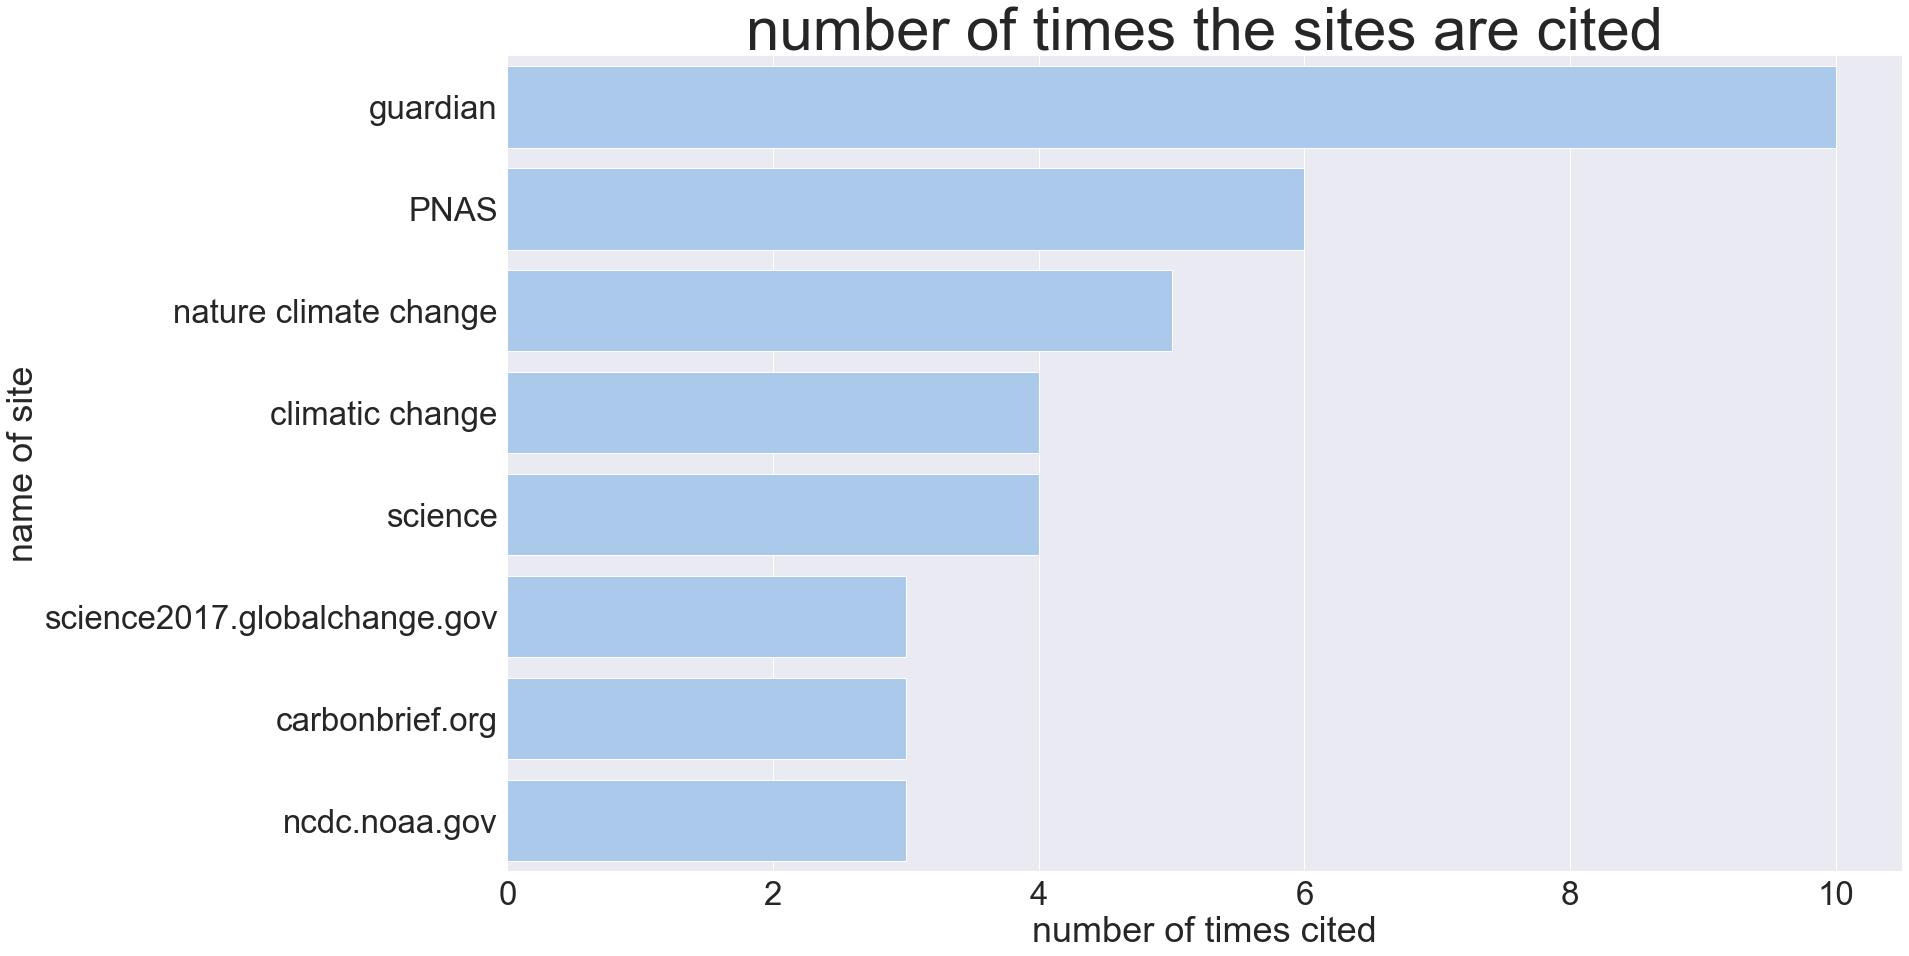

In [173]:
dftot,dico=sortcitation(df.loc[:,"citationtext_total"])
plot_site_most_cited(dftot,2)

<class 'pandas.core.series.Series'>


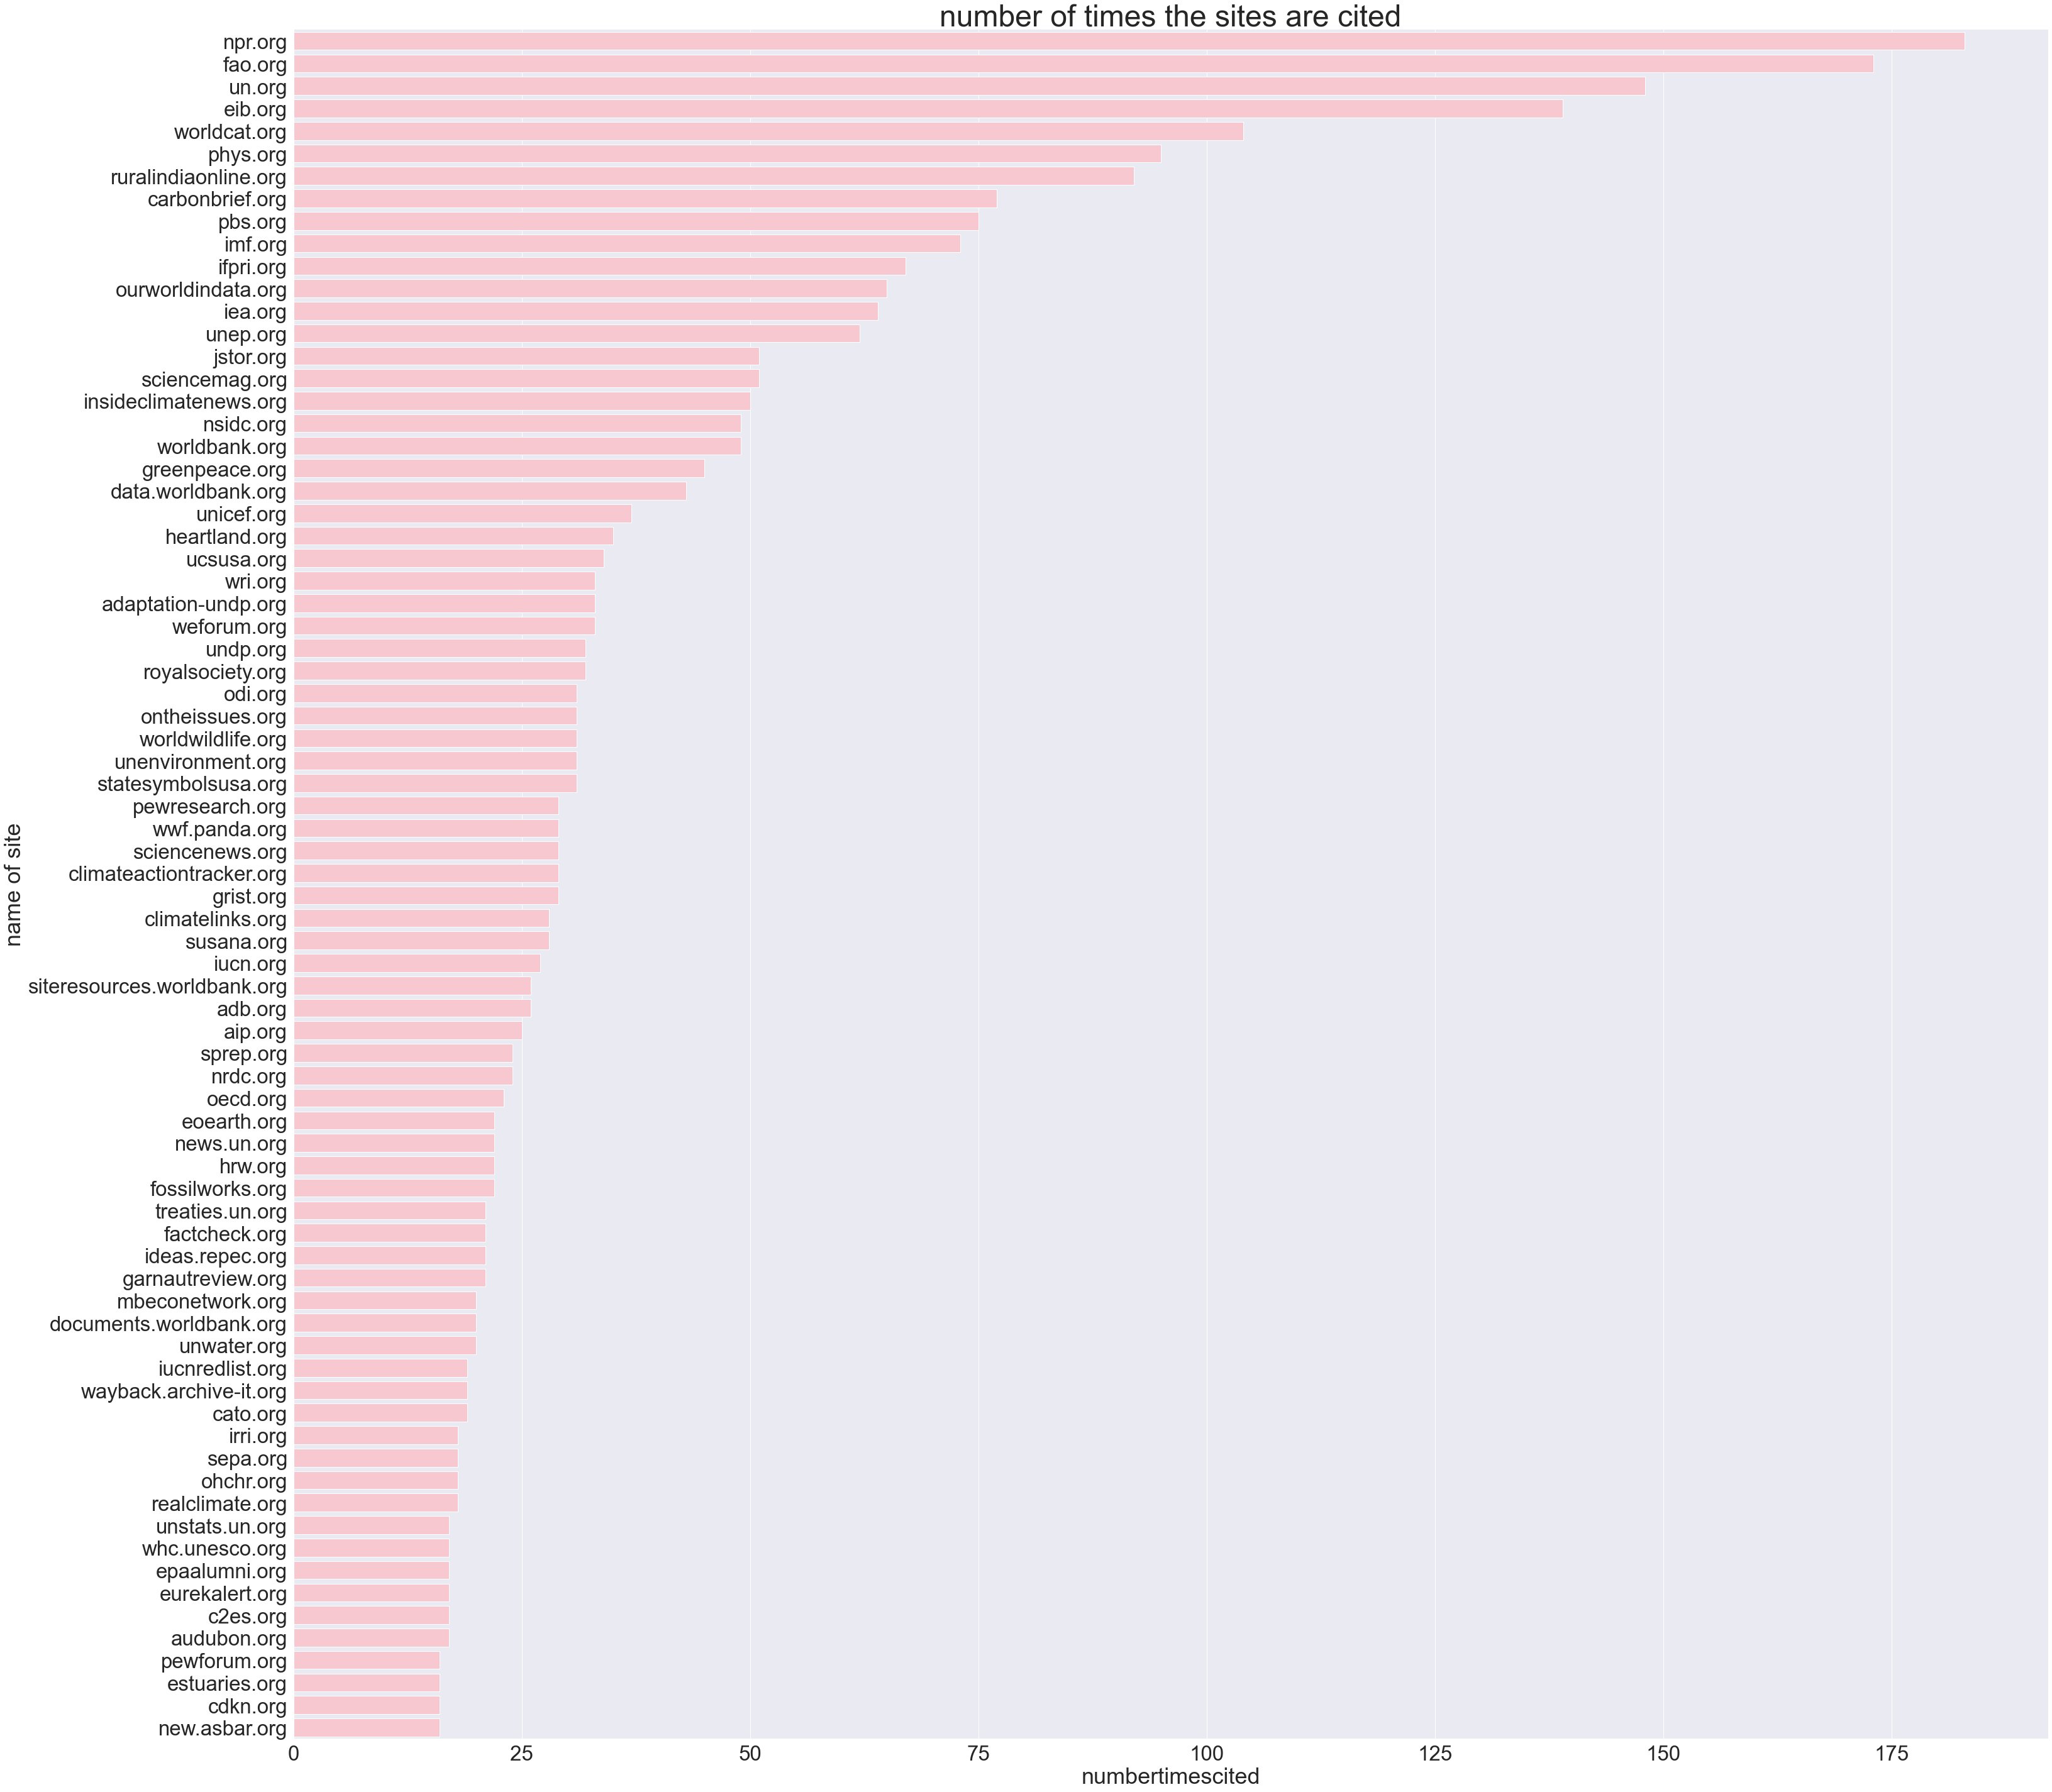

In [94]:
#An example of the plot for .org citation
dforg,dico=sortcitation(df.loc[:,"citationorgtext"])    
plot_site_most_cited(dforg,15)

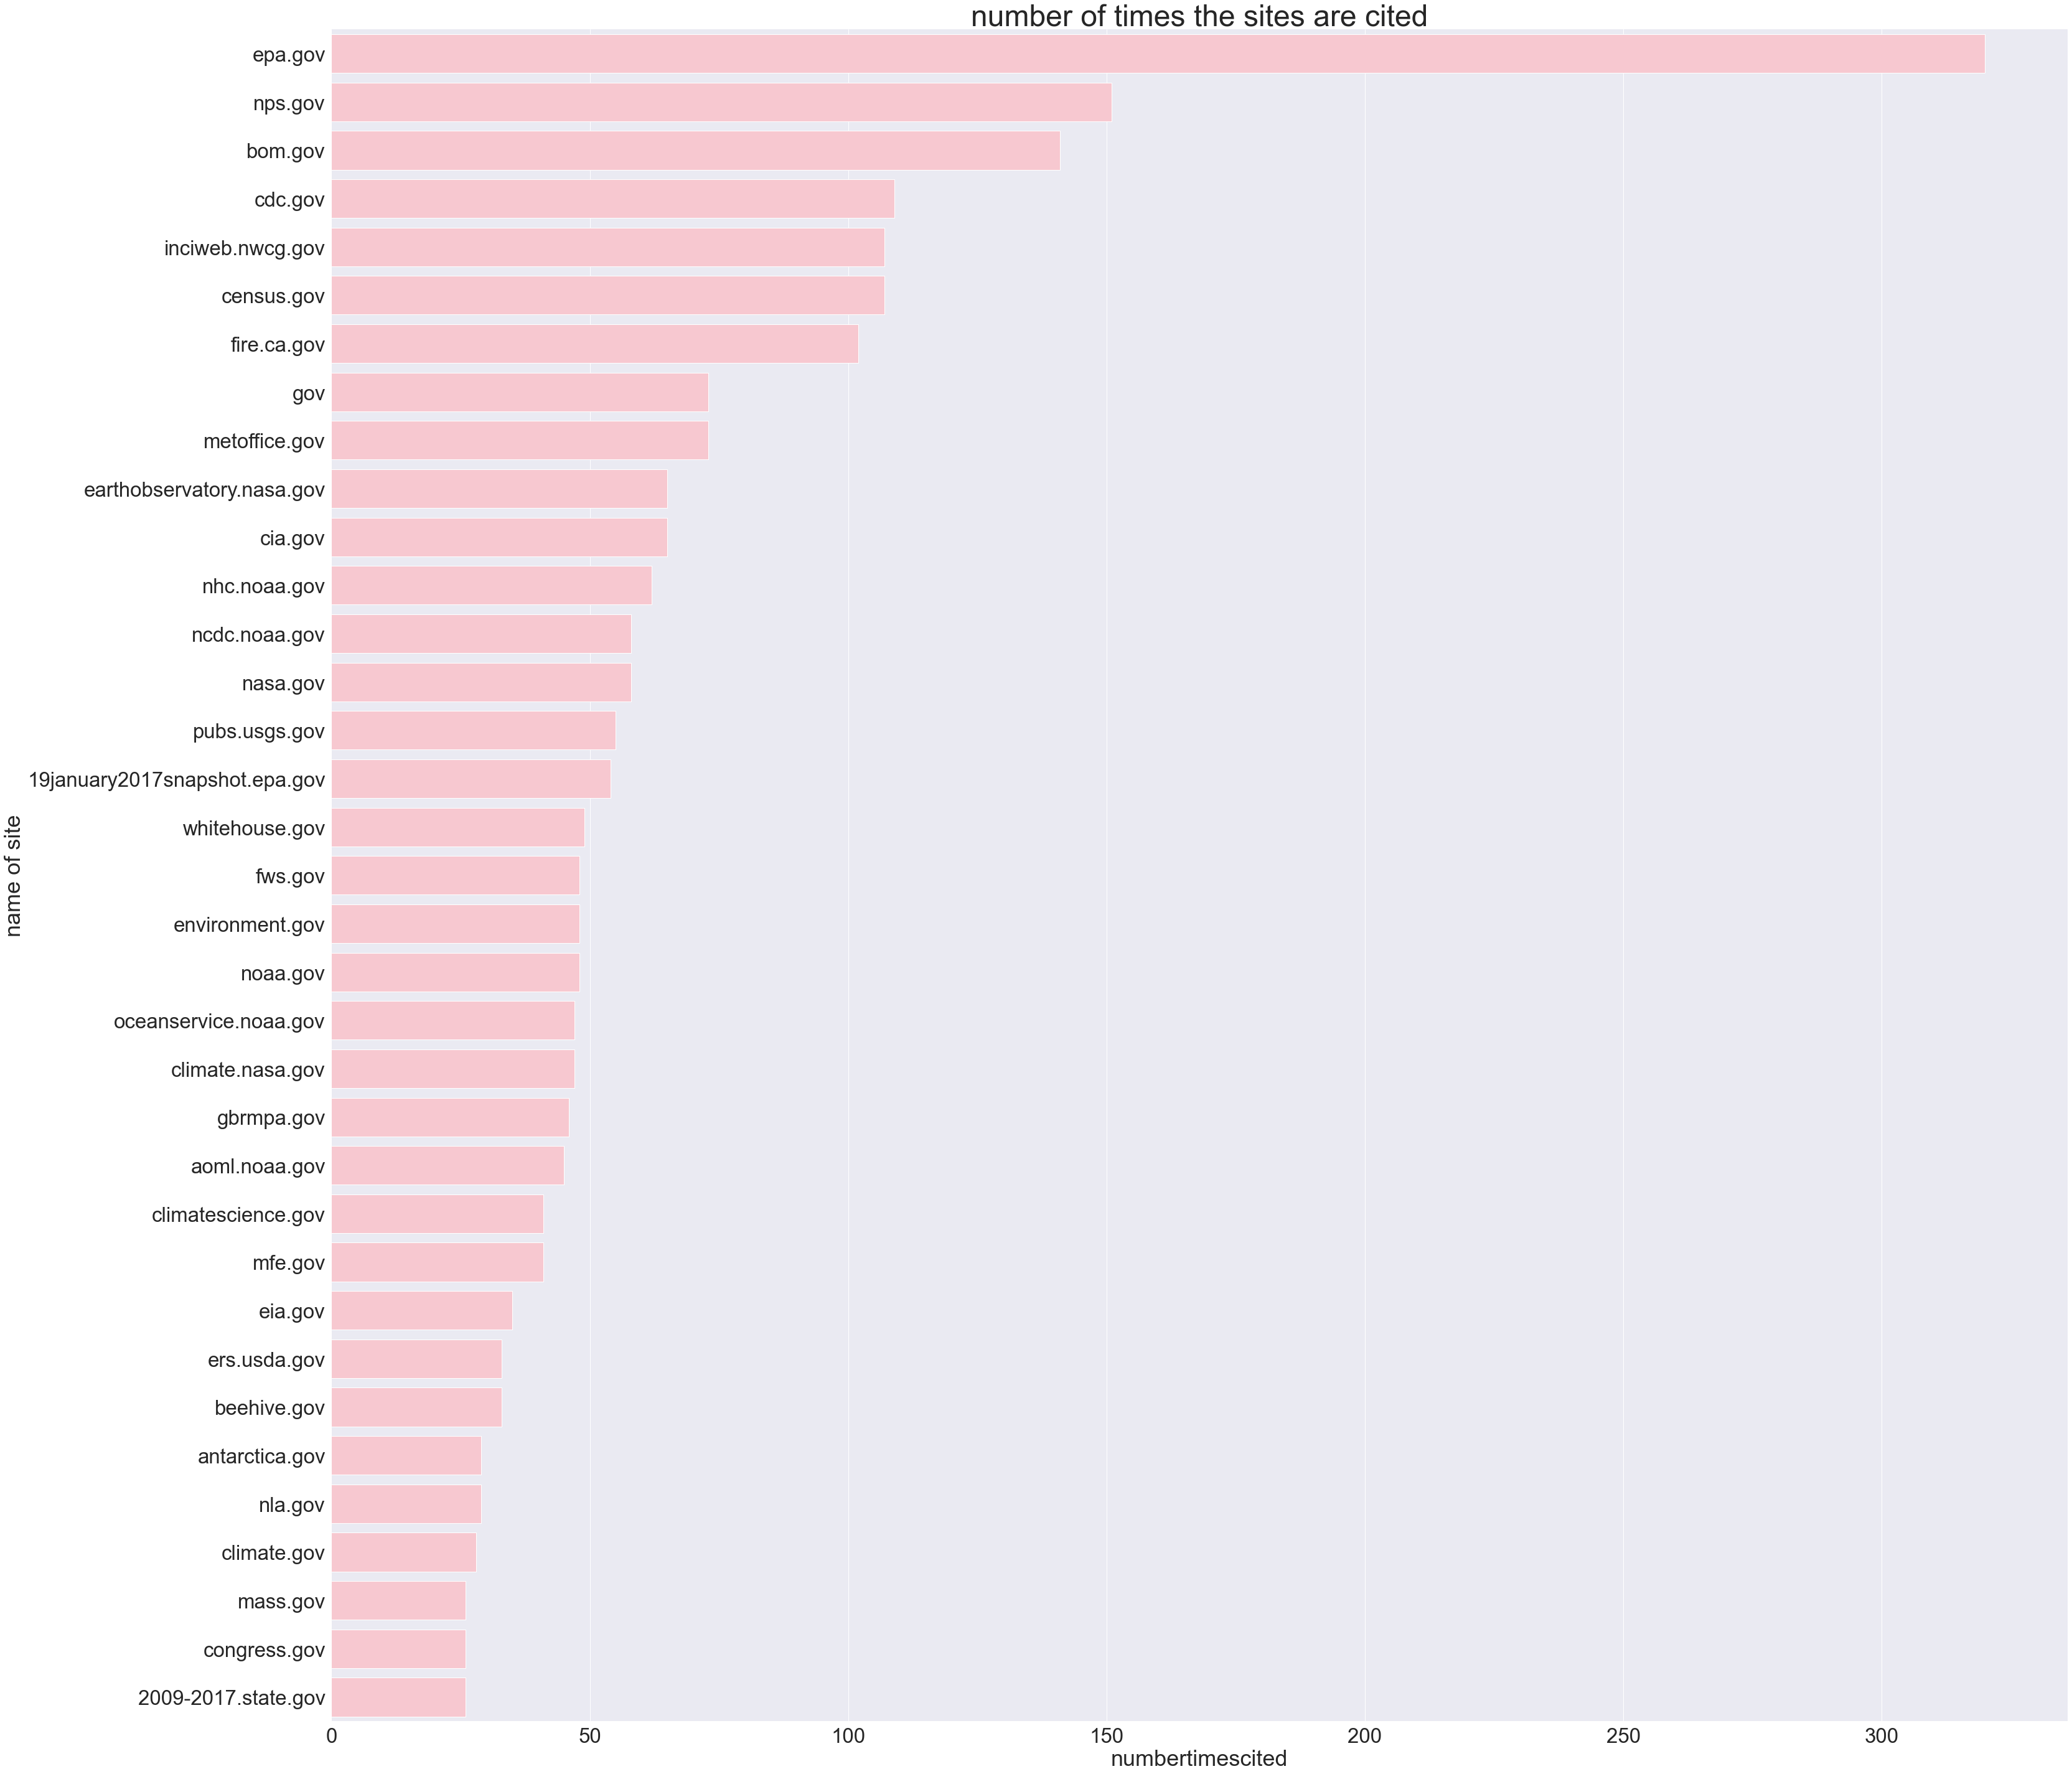

In [78]:
dfgov,j=sortcitation(df.loc[:,"citationgovtext"])
dfgov
plot_site_most_cited(dfgov,25)

                                        name of site  numbertimescited
5                                             nature               136
32                                           science               102
11                    environmental research letters                87
12                             nature climate change                79
6    proceedings of the national academy of sciences                78
..                                               ...               ...
464         international journal of health services                 1
462                             nationalities papers                 1
460                        american economic journal                 1
459                                       nat commun                 1
835        american journal of physical anthropology                 1

[836 rows x 2 columns]


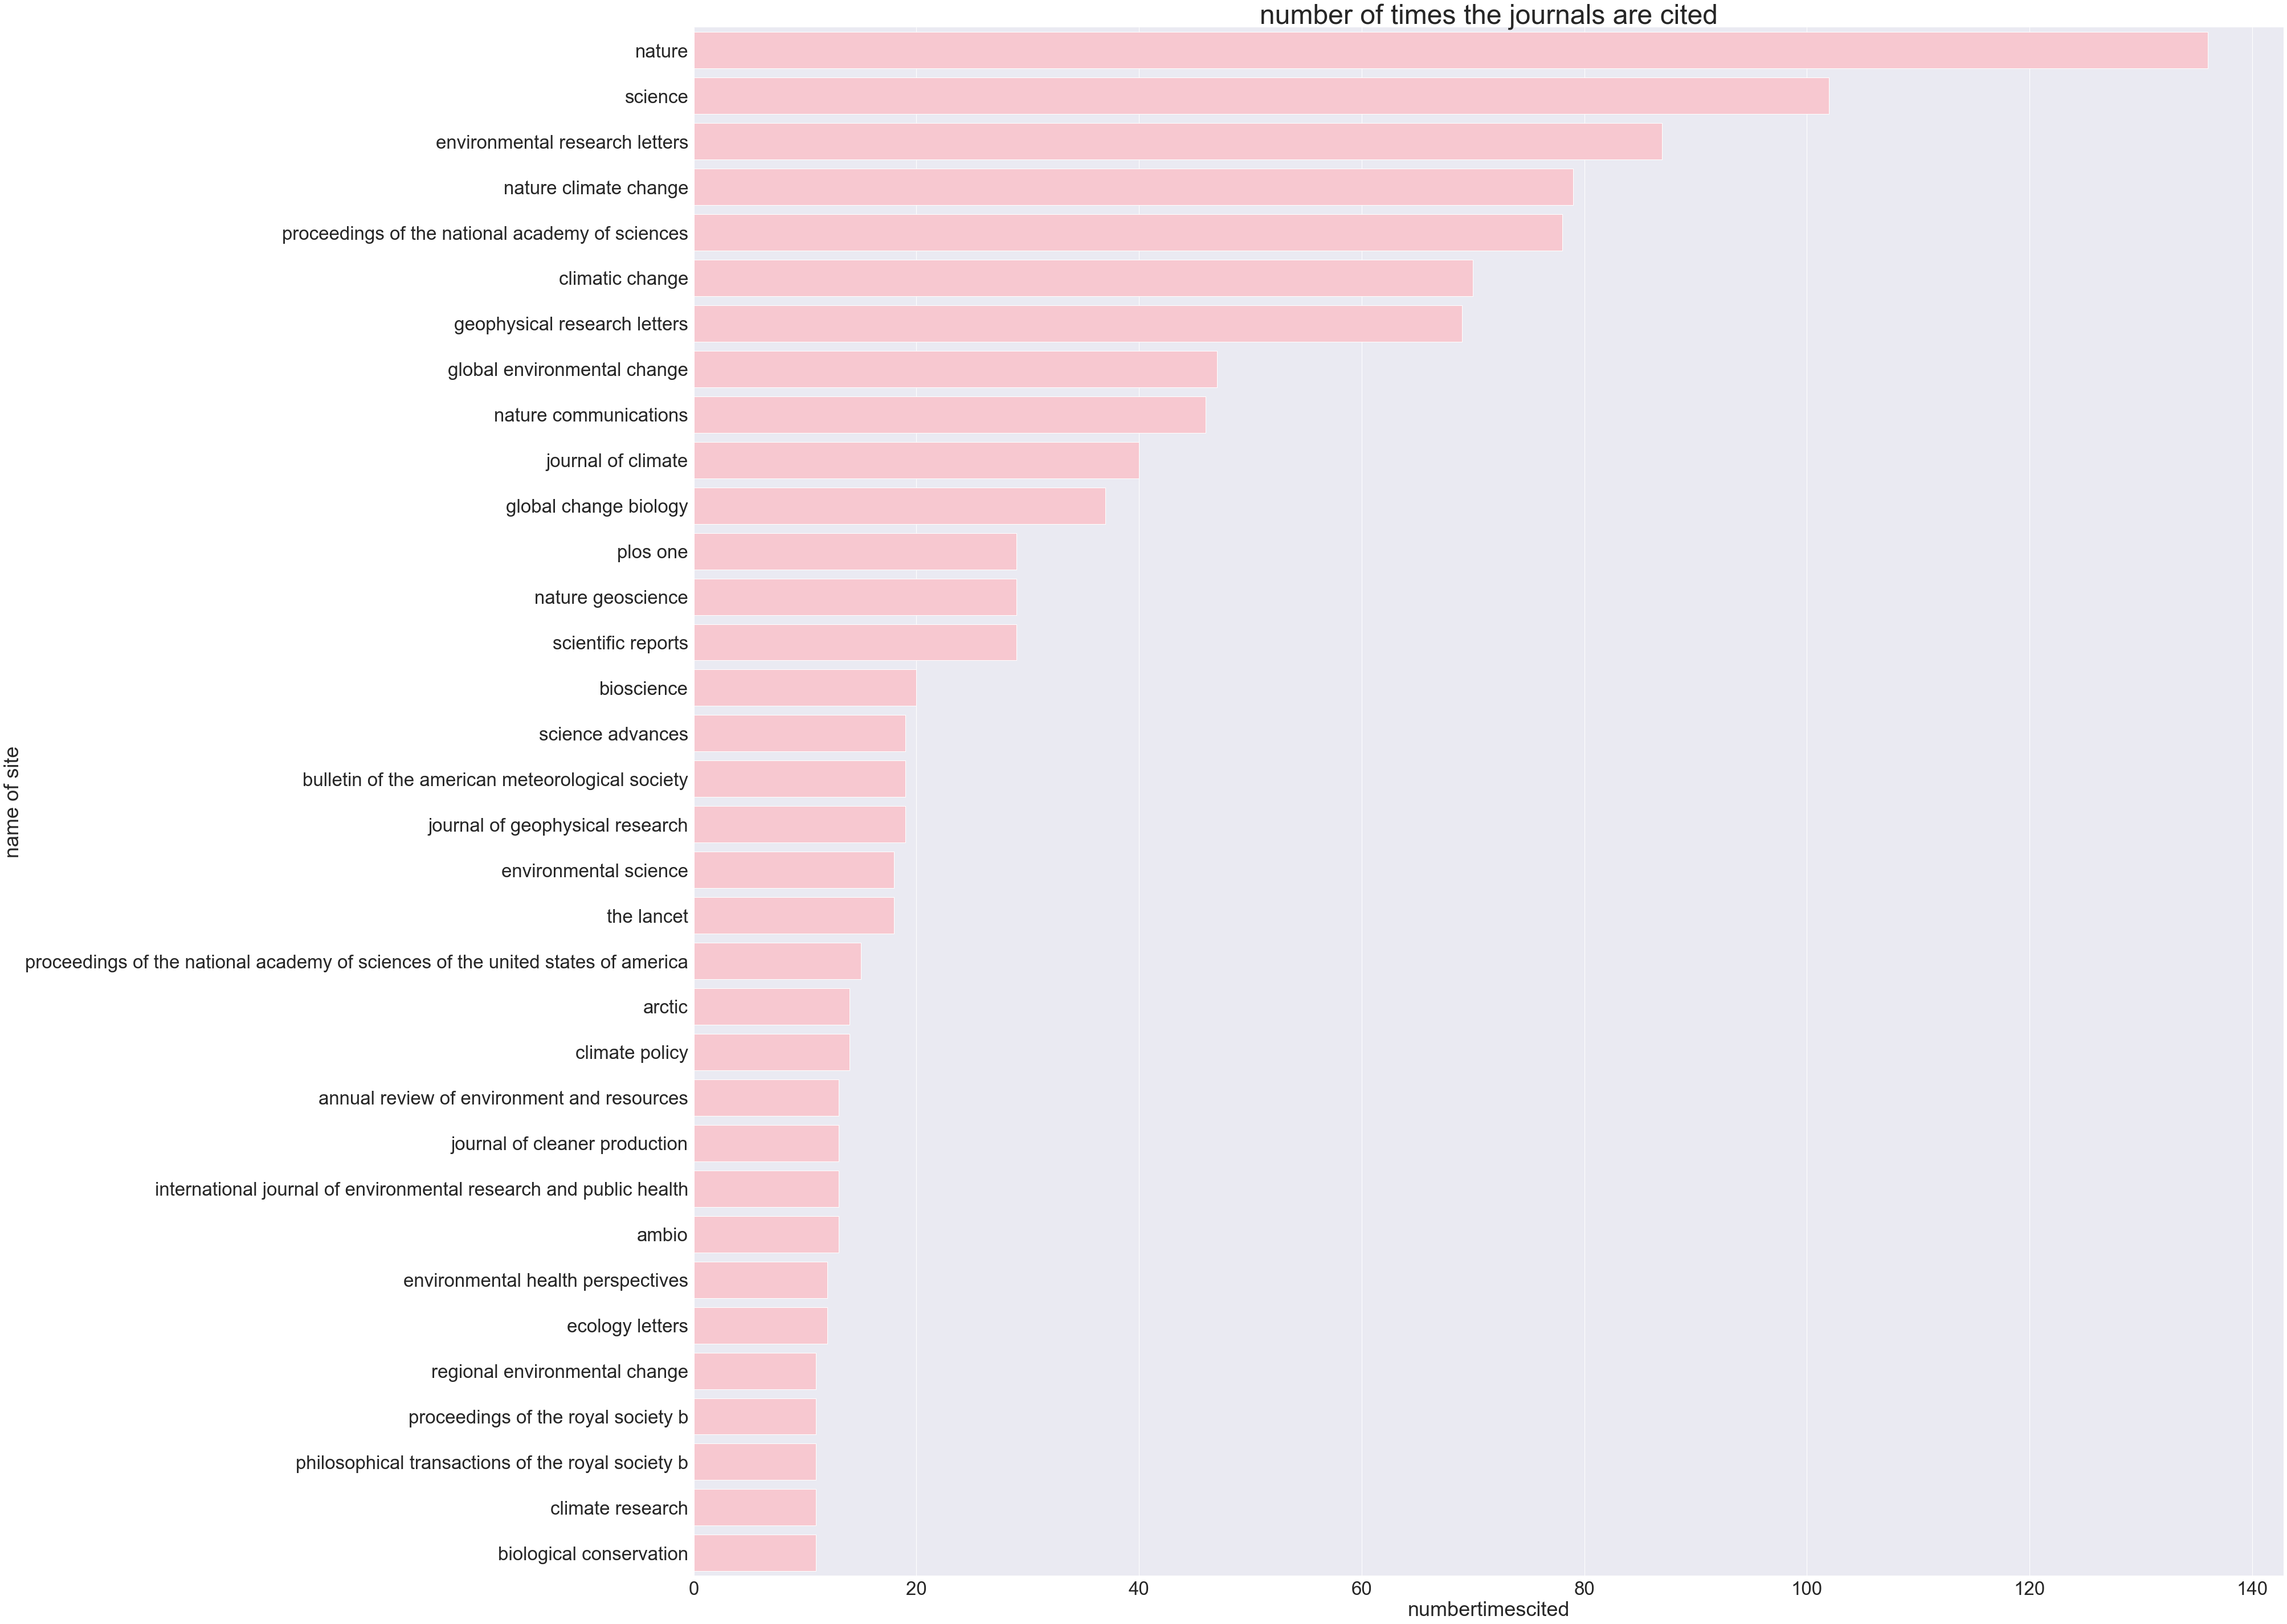

In [42]:
dfsci,j=sortcitation(df.loc[:,"journal"])
print(dfsci)
plot_site_most_cited(dfsci,10)

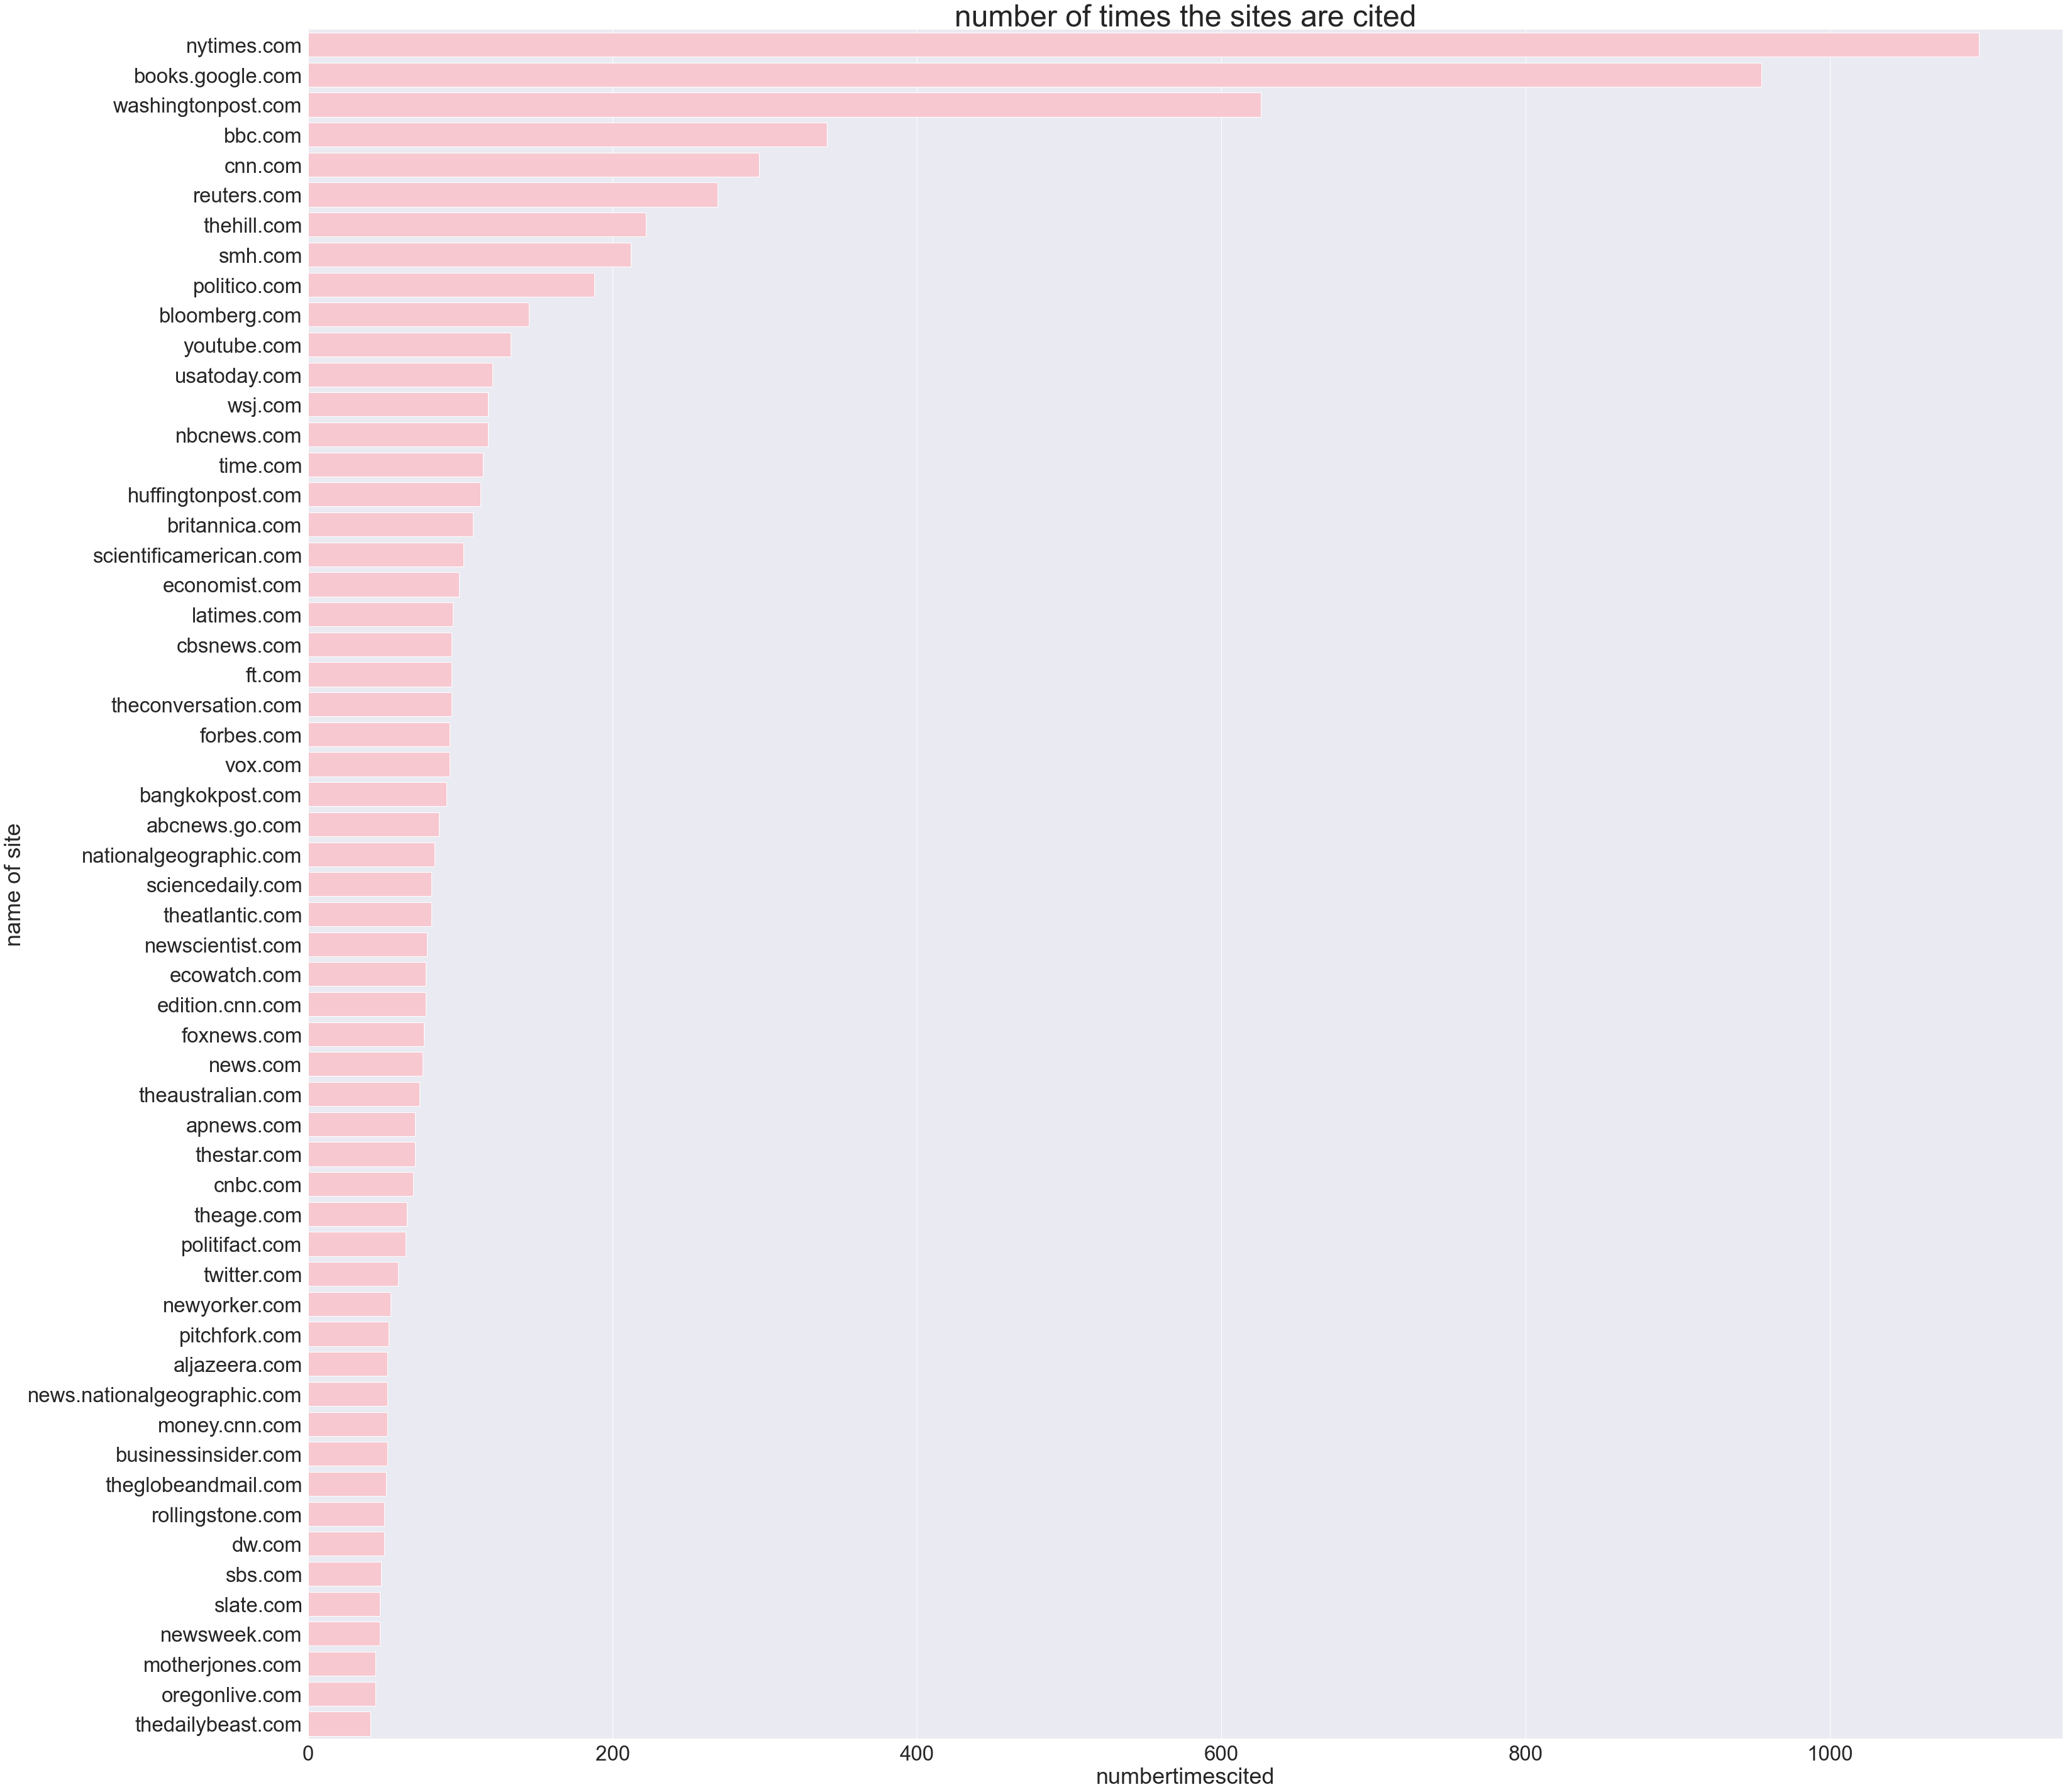

In [82]:
dcom,bl=sortcitation(df.loc[:,"citationcomtext"])
dcom
plot_site_most_cited(dcom,40)

## Cleaning the column and exporting the data frame and scrap of page information

In [35]:
titlelist=df["Name only"].tolist() #make a list will all titles
#We need to recreate the wiki url, first step is to get rid of blanks
titleunderscore = [sub.replace(' ', '_') for sub in titlelist]

In [95]:
#We finally get from the original url to the pageinfo url
urlmodifié = ['https://en.wikipedia.org/w/index.php?title=' + i +'&action=info' for i in titleunderscore]

In [37]:
#Cell to scrap infos from "page info" section (2 to scrap the third table of the page)
doblist=[]
creatorlist=[]
totaledits=[]
recentedits=[]
pageid=[]
pagelenght=[]
editprotection=[]
recentpageviews=[]

for i in tqdm(urlmodifié) :
    source = requests.get(i)
    soup = BeautifulSoup(source.text, 'lxml')
    alltables=soup.findAll('table', {"class": "wikitable mw-page-info"})
    tableau_html_liste=pd.read_html(str(alltables)) #We get it as a list   
    df_pageinfo2=pd.DataFrame(tableau_html_liste[2]) #And make it a df 
    #The number between brackets corresponds to the number of the table according to its order on the html page
    creatorlist += [df_pageinfo2.iat[0, 1]]
    doblist += [df_pageinfo2.iat[1, 1]]
    totaledits += [df_pageinfo2.iat[4, 1]]
    recentedits += [df_pageinfo2.iat[5, 1]]
    
    
    #Scrap of the first table of the page (0)
    df_pageinfo0=pd.DataFrame(tableau_html_liste[0])
    pagelenght += [df_pageinfo0.iat[2, 1]]
    pageid += [df_pageinfo0.iat[3, 1]]
            
    
    #Scrap of the second table of the page (1)
    df_pageinfo1=pd.DataFrame(tableau_html_liste[1])
    editprotection += [df_pageinfo1.iat[1, 1]]
  

    

100%|████████████████████████████████████████████████████████████████████████████████| 921/921 [11:49<00:00,  1.30it/s]


In [38]:
#Cell to add the new lists as new columns of the df
df["Page id"]=pageid
df["Edit protection"]=editprotection
df["Page lenght (Bytes)"]=pagelenght
df["DOB"]=doblist
df["Creator"]=creatorlist
df["Total edits"]=totaledits
df["Recent edits"]=recentedits
df.head()

Name only  \
Creator                                                 
Rd232                       Effects of climate change   
Jarble       Effects of climate change on agriculture   
Ppowers29   Effects of climate change on human health   
Antblasko         Effects of climate change on oceans   
Enescot       Effects of climate change on ecosystems   

                                                     page url  \
Creator                                                         
Rd232       https://en.wikipedia.org/wiki/Effects_of_clima...   
Jarble      https://en.wikipedia.org/wiki/Effects_of_clima...   
Ppowers29   https://en.wikipedia.org/wiki/Effects_of_clima...   
Antblasko   https://en.wikipedia.org/wiki/Effects_of_clima...   
Enescot     https://en.wikipedia.org/wiki/Effects_of_clima...   

                                                         text  \
Creator                                                         
Rd232       {{short description|Effects created by climate...   
Jarble      {{short description|None}}\n{{about||contribut...   
Ppowers29   [[File:Atlanta thermal.jpg|thumb|Illustration ...   
Antblasko   {{Short description|Effects of climate change ...   
Enescot     {{short description|How increased greenhouse g...   

                                                    citations  Ref count  \
Creator                                                                    
Rd232       {'Ref count': 252, 'nb_journal_citations': 58,...        252   
Jarble      {'Ref count': 142, 'nb_journal_citations': 51,...        142   
Ppowers29   {'Ref count': 111, 'nb_journal_citations': 56,...        111   
Antblasko   {'Ref count': 121, 'nb_journal_citations': 66,...        121   
Enescot     {'Ref count': 86, 'nb_journal_citations': 49, ...         86   

            nb_journal_citations  \
Creator                            
Rd232                         58   
Jarble                        51   
Ppowers29                     56   
Antblasko                     66   
Enescot                       49   

                                              journalcitation  \
Creator                                                         
Rd232       [10.1023/b:clim.0000004559.08755.88, 10.2105/a...   
Jarble      [10.1111/j.1365-3059.2010.02411.x, 10.1016/s01...   
Ppowers29   [10.2215/cjn.13841215, 10.1111/j.1365-3059.201...   
Antblasko   [10.1175/jhm600.1, 10.1073/pnas.0630310100, 10...   
Enescot     [10.1371/journal.pone.0065427, 10.1890/120282,...   

                                                      journal  citation org  \
Creator                                                                       
Rd232       [[climatic change], [american journal of publi...            27   
Jarble      [[plant pathology ], [trends in ecology ], [ca...            19   
Ppowers29   [[clin j am soc nephrol ], [plant pathology ],...            13   
Antblasko   [[journal of hydrometeorology ], [proceedings ...            14   
Enescot     [[plos one ], [frontiers in ecology and the en...             7   

                                              citationorgtext  ...   Page id  \
Creator                                                        ...             
Rd232       [openknowledge.worldbank.org, www.carbonbrief....  ...   2119174   
Jarble      [www.fao.org, www.sciencenews.org, www.unenvir...  ...  47512577   
Ppowers29   [environmentlive.unep.org, phys.org, www.grist...  ...  37063005   
Antblasko   [www.worldcat.org, www.sciencemag.org, worldca...  ...  35895879   
Enescot     [www.npr.org, www.un.org, www.nwf.org, worldca...  ...  26515241   

                                              Edit protection  \
Creator                                                         
Rd232       Require autoconfirmed or confirmed access (no ...   
Jarble                        Allow all users (no expiry set)   
Ppowers29                     Allow all users (no expiry set)   
Antblasko                     Allow all users (no 

In [39]:
#Cleaning the table

#Getting rid of the time
df["DOB"]= df["DOB"].str.slice(7,100,1) 
#peutêtre qu'on pourrait mettre comme end point la len de la string

#Format the date
df["Formated DOB"]=pd.to_datetime(df["DOB"], format='%d %B %Y')
df["Year_month"]= pd.to_datetime(df['DOB']).dt.to_period('M')

#Getting the year
df['Year'] = pd.DatetimeIndex(df['DOB']).year

#Cleaning the creator 
df["Creator"]= df["Creator"].str.replace(r"\(.*\)",'', regex=True)

#### Plot the ratio of page created by a certain editor in our corpus

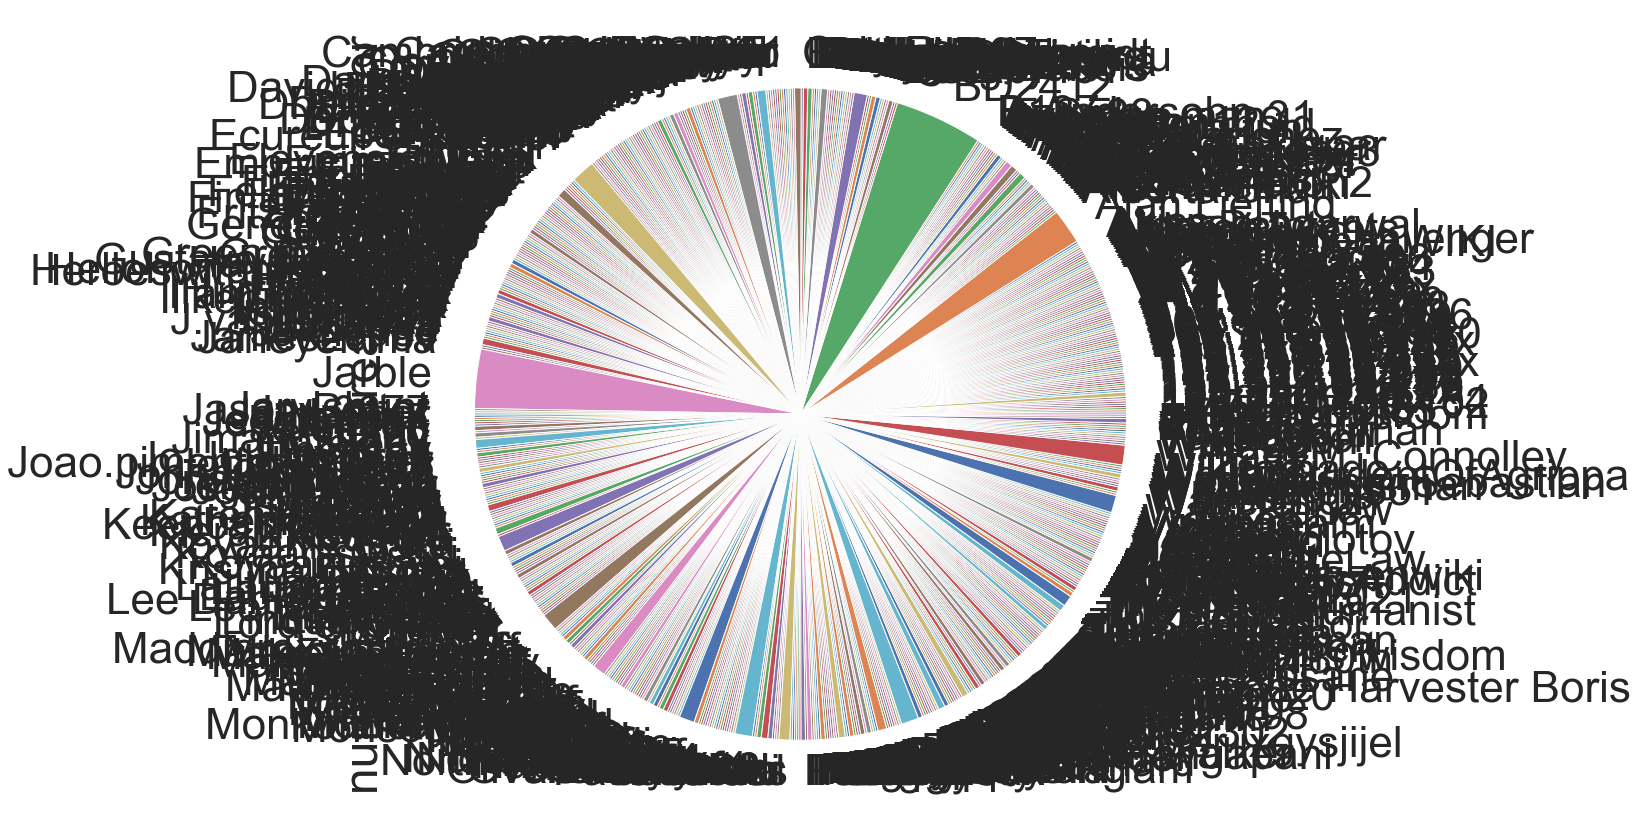

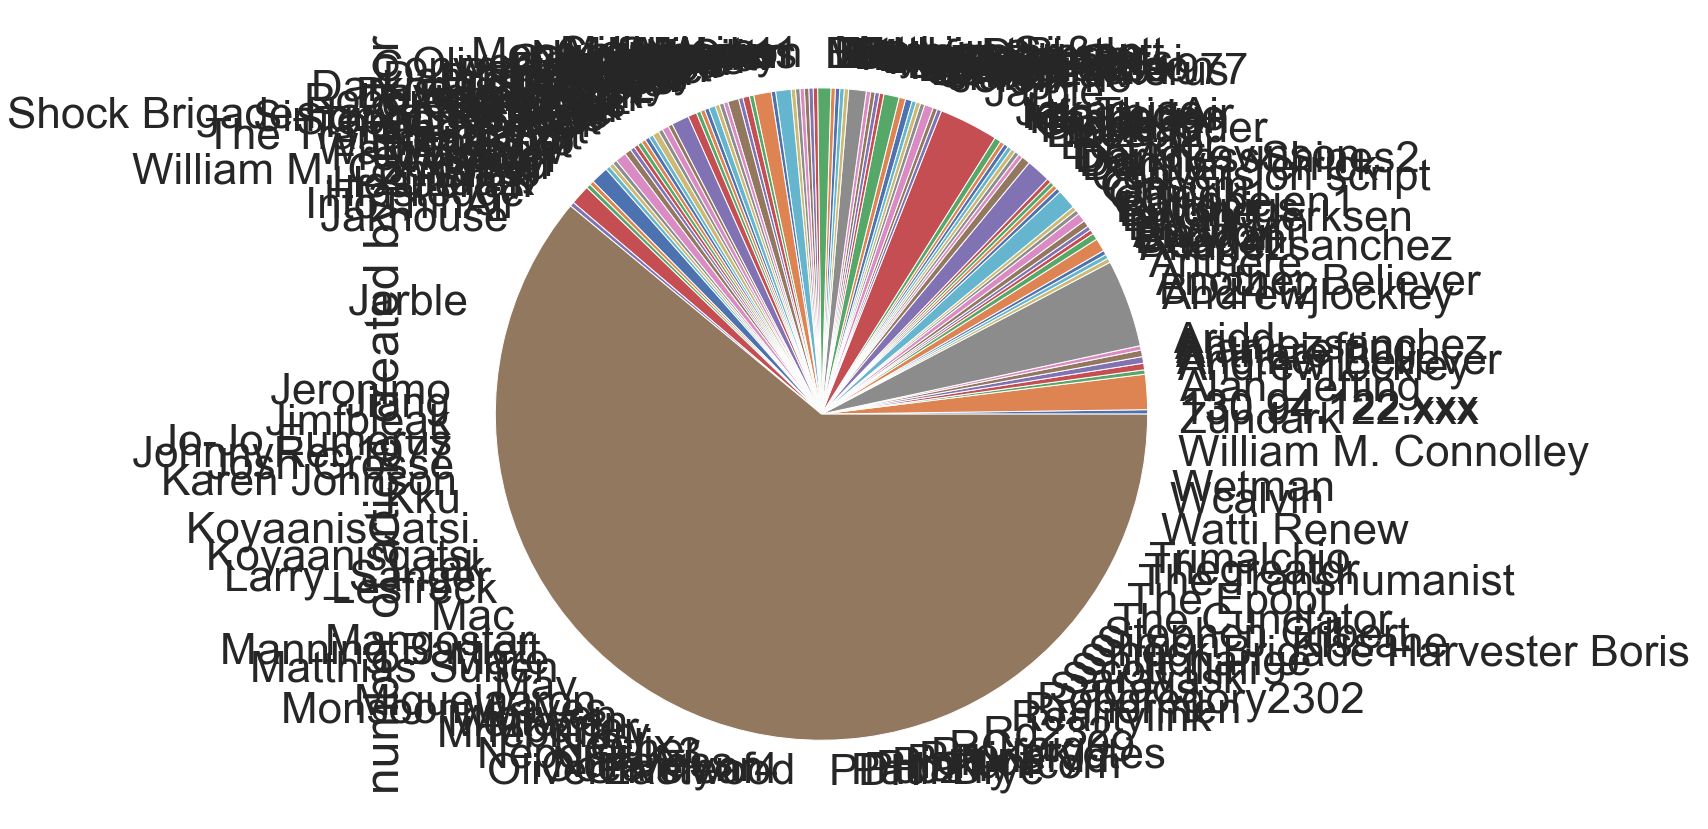

Name only  \
Creator                                                   
Rd232                         Effects of climate change   
Jarble         Effects of climate change on agriculture   
Ppowers29     Effects of climate change on human health   
Antblasko           Effects of climate change on oceans   
Enescot         Effects of climate change on ecosystems   
...                                                 ...   
Dchensummer                 Restore America's Estuaries   
Dmtk                                      Carbon bubble   
J579513                          The Hunting Hypothesis   
Fish720                         David Quinn (columnist)   
Leinad-Z                 Crisis of the Late Middle Ages   

                                                       page url  \
Creator                                                           
Rd232         https://en.wikipedia.org/wiki/Effects_of_clima...   
Jarble        https://en.wikipedia.org/wiki/Effects_of_clima...   
Ppowers29     https://en.wikipedia.org/wiki/Effects_of_clima...   
Antblasko     https://en.wikipedia.org/wiki/Effects_of_clima...   
Enescot       https://en.wikipedia.org/wiki/Effects_of_clima...   
...                                                         ...   
Dchensummer   https://en.wikipedia.org/wiki/Restore_America%...   
Dmtk                https://en.wikipedia.org/wiki/Carbon_bubble   
J579513       https://en.wikipedia.org/wiki/The_Hunting_Hypo...   
Fish720       https://en.wikipedia.org/wiki/David_Quinn_(col...   
Leinad-Z      https://en.wikipedia.org/wiki/Crisis_of_the_La...   

                                                           text  \
Creator                                                           
Rd232         {{short description|Effects created by climate...   
Jarble        {{short description|None}}\n{{about||contribut...   
Ppowers29     [[File:Atlanta thermal.jpg|thumb|Illustration ...   
Antblasko     {{Short description|Effects of climate change ...   
Enescot       {{short description|How increased greenhouse g...   
...                                                         ...   
Dchensummer   ["RAE also has focused on the impacts of clima...   
Dmtk          ['A detailed academic study of the consequence...   
J579513       ['\'\'The Hunting Hypothesis\'\' was also one ...   
Fish720       ['\nQuinn is highly outspoken in his denial of...   
Leinad-Z      ['The Black Death was a particularly devastati...   

                                                      citations  Ref count  \
Creator                                                                      
Rd232         {'Ref count': 252, 'nb_journal_citations': 58,...        252   
Jarble        {'Ref count': 142, 'nb_journal_citations': 51,...        142   
Ppowers29     {'Ref count': 111, 'nb_journal_citations': 56,...        111   
Antblasko     {'Ref count': 121, 'nb_journal_citations': 66,...        121   
Enescot       {'Ref count': 86, 'nb_journal_citations': 49, ...         86   
...                                                         ...        ...   
Dchensummer   {'Ref count': 1, 'nb_journal_citations': 0, 'c...          1   
Dmtk          {'Ref count': 5, 'nb_journal_citations': 2, 'c...          5   
J579513       {'Ref count': 1, 'nb_journal_citations': 0, 'c...          1   
Fish720       {'Ref count': 13, 'nb_journal_citations': 0, '...         13   
Leinad-Z      {'Ref count': 3, 'nb_journal_citations': 3, 'c...          3   

              nb_journal_citations  \
Creator                              
Rd232                           58   
Jarble                          51   
Ppowers29                       56   
Antblasko                       66   
Enescot                         49   
...                            ...   
Dchensummer                      0   
Dmtk                             2   
J579513                          0   
Fish720                          0   
Leinad-Z                         3   

                        

In [40]:
#creation of a new dataframe
dfbis=df

dfbis["number of article created by creator"]=1
dfbis.set_index("Creator",inplace=True)
dfbis=dfbis.groupby("Creator")["number of article created by creator"].sum()

fig = plt.figure(0,figsize=(20,15))
dfbis.plot.pie(subplots=True)
fig.savefig('article_created_by_creator.jpg', bbox_inches='tight', dpi=150)

fig2 = plt.figure(1,figsize=(20,15))
dfwithoutother=dfbis[dfbis>1]
dfwithoutother.plot.pie(subplots=True)

dftris=dfbis[dfbis==1].sum()
dfbis.loc["Other"]=dftris


fig3 = plt.figure(1,figsize=(20,15))
dfbis[dfbis>1].plot.pie(subplots=True)
fig2.savefig('article_created_by_important_creator.jpg', bbox_inches='tight', dpi=150)

plt.show()
df

#### plot of the timeline

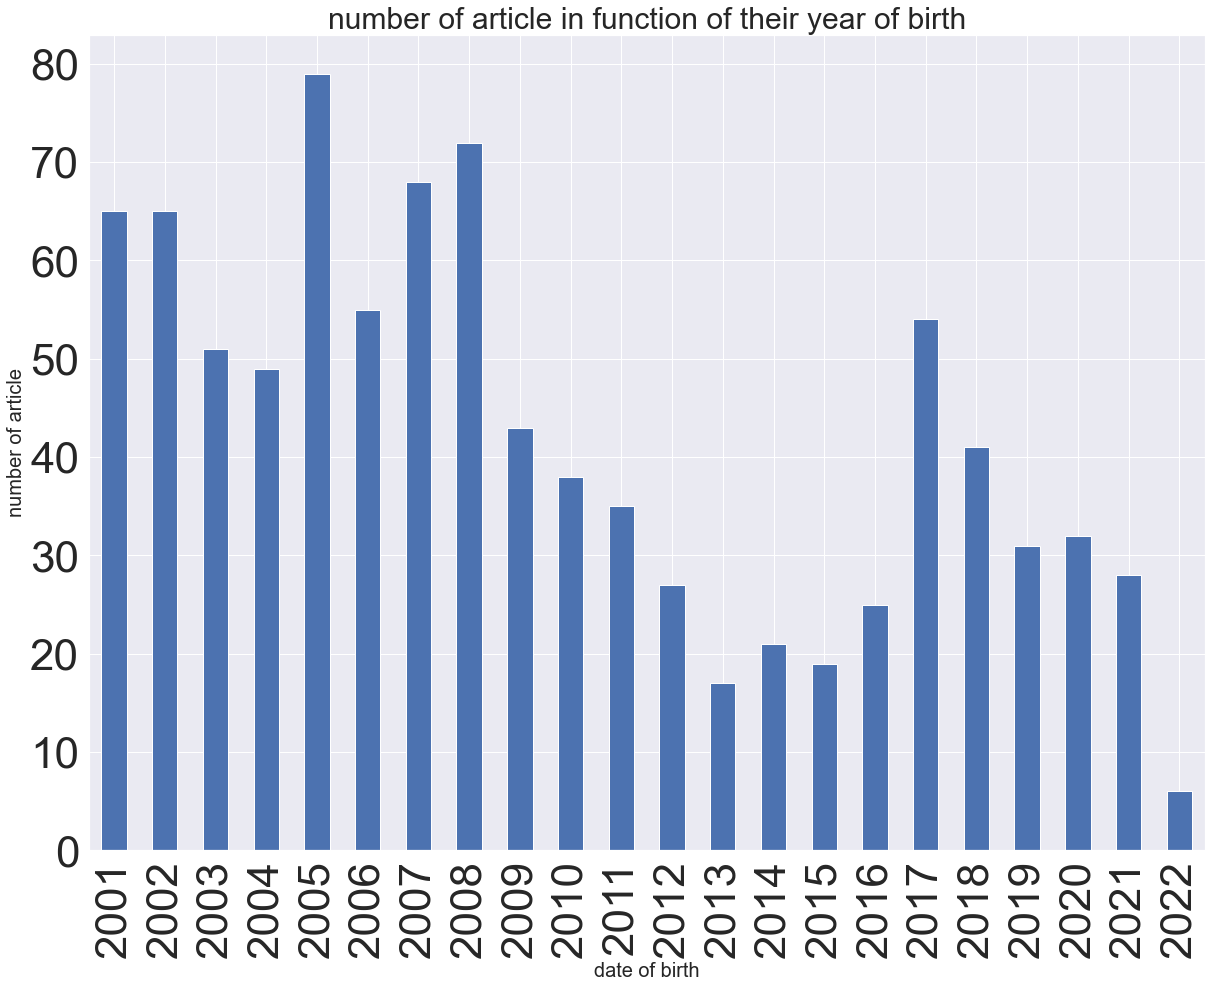

In [37]:
fig = plt.figure(0,figsize=(20,15))
plothist=df["Year"].value_counts().sort_index().plot(kind="bar")
fig.savefig('timeline.jpg', bbox_inches='tight', dpi=150)
plt.xlabel('date of birth',fontsize = 20) 
plt.ylabel('number of article',fontsize = 20) 
plt.title("number of article in function of their year of birth",fontsize = 30)
plt.show()

#### Clean and export the dataframes to csv

In [258]:
del df['citationorgtext']
del df['citationgovtext']
del df['text']
del df["citations"]
del df["citationcomtext"]

In [74]:
df

Unnamed: 0                                         Name only  \
0             0                         Effects of climate change   
1             1                                    Climate change   
2             2  Effects of climate change on terrestrial animals   
3             3                 History of climate change science   
4             4                       Climate change in Australia   
..          ...                                               ...   
702         702               North Indian Ocean tropical cyclone   
703         703                                   Steller's eider   
704         704                                   Agulhas Leakage   
705         705                                 Energy in Finland   
706         706                                    Ectomycorrhiza   

                                              page url  \
0    https://en.wikipedia.org/wiki/Effects_of_clima...   
1         https://en.wikipedia.org/wiki/Climate_change   
2    https://en.wikipedia.org/wiki/Effects_of_clima...   
3    https://en.wikipedia.org/wiki/History_of_clima...   
4    https://en.wikipedia.org/wiki/Climate_change_i...   
..                                                 ...   
702  https://en.wikipedia.org/wiki/North_Indian_Oce...   
703    https://en.wikipedia.org/wiki/Steller%27s_eider   
704      https://en.wikipedia.org/wiki/Agulhas_Leakage   
705    https://en.wikipedia.org/wiki/Energy_in_Finland   
706       https://en.wikipedia.org/wiki/Ectomycorrhiza   

                                                  text  \
0    {{short description|Effects created by climate...   
1    {{Short description|Current rise in Earth's av...   
2    {{Multiple issues|\r\n{{cleanup reorganize|dat...   
3    {{short description|Aspect of the history of s...   
4    {{Short description|Impacts of climate change ...   
..                                                 ...   
702  {{Short description|Wikipedia article about th...   
703  {{short description|Species of bird}}\r\n{{spe...   
704  The '''Agulhas Leakage''' is an inflow of anom...   
705  {{Use dmy dates|date=June 2020}}\r\n[[File:Ene...   
706  {{Short description|Non-penetrative symbiotic ...   

                                             citations  Ref count  \
0    {'Ref count': 252, 'nb_journal_citations': 58,...        252   
1    {'Ref count': 603, 'nb_journal_citations': 114...        603   
2    {'Ref count': 67, 'nb_journal_citations': 47, ...         67   
3    {'Ref count': 91, 'nb_journal_citations': 28, ...         91   
4    {'Ref count': 179, 'nb_journal_citations': 19,...        179   
..                                                 ...        ...   
702  {'Ref count': 39, 'nb_journal_citations': 1, '...         39   
703  {'Ref count': 34, 'nb_journal_citations': 16, ...         34   
704  {'Ref count': 21, 'nb_journal_citations': 20, ...         21   
705  {'Ref count': 66, 'nb_journal_citations': 0, '...         66   
706  {'Ref count': 122, 'nb_journal_citations': 108...        122   

     nb_journal_citations                                    journalcitation  \
0                      58  [10.1126/science.240.4855.996, 10.1016/j.cosus...   
1                     114  [10.1146/annurev-chembioeng-060816-101538, 10....   
2                      47  [10.1098/rsbl.2009.1024, 10.1186/s13750-020-00...   
3                      28  [10.1175/2008bams2370.1, 10.1016/0033-5894(72)...   
4                      19  [10.1007/s00484-010-0320-6, 10.1016/j.gloenvch...   
..                    ...                                                ...   
702                     1                   [10.1002/jgrd.50396, None, None]   
703                    16  [10.2307/3533677, 10.3996/nafa.81.0001, 10.144...   
704                    20  [10.1175/2011jpo4602.1, 10.1029/2006gl028044, ...   
705                     0                                                 []   
706                   108  [10.1007/bf01972080, 10.1016/j.soilbio.2010.01

In [86]:

df.to_csv('CRISPR.csv')

In [49]:
#extract the data frame to csv
df.to_csv('climatechange‧csv')
dforg.to_csv('climatechangeorg.csv')
dfgov.to_csv('climatechangegov.csv')
dcom.to_csv('climatechangecom.csv')

"\ndfgov.to_csv('climatechangegov.csv')\ndcom.to_csv('climatechangecom.csv')"